#### Rohan Bhatt, Shubhang Srikoti 
##### MSML605 -  Investigating the Impact of Storage Formats
Problem statement: How does the choice of storage format (CSV, Parquet, HDF5) impact the overall performance of a machine learning pipeline and its processes (data ingestion, memory overhead, time-to-train, and more).




In [11]:
import kagglehub
path = kagglehub.dataset_download("jtbontinck/amex-parquet-file")
print("Path to dataset files:", path)

100%|██████████| 8.99G/8.99G [06:21<00:00, 25.3MB/s]

Extracting files...


Path to dataset files: /Users/rohan/.cache/kagglehub/datasets/jtbontinck/amex-parquet-file/versions/1


In [12]:
# #THIS SCRIPT ACTUALLY ENDED UP INCREASING MY FILE SIZE to 12GB WHICH I USED GOING FORWARD

# #tried script to convert 10gb parquet to 2gb parquet
# import pyarrow.parquet as pq, pyarrow as pa, math
# from pathlib import Path

# SRC = Path("data.parquet")          # 16-GB file
# DST = Path("data_2gb.parquet")

# pq_src   = pq.ParquetFile(SRC)
# n_rg     = pq_src.num_row_groups

# # gather row-group sizes (compressed bytes on disk)
# rg_sizes = [pq_src.metadata.row_group(i).total_byte_size for i in range(n_rg)]

# target_bytes = 2 * 1024**3          # 2 GB
# keep_rg      = []
# cum          = 0
# for i, sz in enumerate(rg_sizes):
#     if cum + sz > target_bytes:
#         break
#     keep_rg.append(i)
#     cum += sz

# print(f"Keeping {len(keep_rg)} row-groups  →  ~{cum/1024**3:.2f} GB")

# # read & write subset
# tables = [pq_src.read_row_group(i) for i in keep_rg]
# subset = pa.concat_tables(tables)
# pq.write_table(subset, DST, compression="snappy")   # or "zstd"

# print(f"Subset rows: {subset.num_rows:,}")
# print("Wrote:", DST)

In [13]:
import pyarrow.parquet as pq
#sanity check of parquet file
pq_file = pq.ParquetFile("data.parquet")
print("Rows in file:", pq_file.metadata.num_rows)
print("Columns in file:", pq_file.metadata.num_columns)
print("Schema:", pq_file.schema)

Rows in file: 16895213
Columns in file: 193
Schema: <pyarrow._parquet.ParquetSchema object at 0x112aa7ac0>
required group field_id=-1 duckdb_schema {
  optional fixed_len_byte_array(16) field_id=-1 line_ID (UUID);
  optional binary field_id=-1 customer_ID (String);
  optional int64 field_id=-1 date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional float field_id=-1 P_2;
  optional float field_id=-1 D_39;
  optional float field_id=-1 B_1;
  optional float field_id=-1 B_2;
  optional float field_id=-1 R_1;
  optional float field_id=-1 S_3;
  optional float field_id=-1 D_41;
  optional float field_id=-1 B_3;
  optional float field_id=-1 D_42;
  optional float field_id=-1 D_43;
  optional float field_id=-1 D_44;
  optional float field_id=-1 B_4;
  optional float field_id=-1 D_45;
  optional float field_id=-1 B_5;
  optional float field_id=-1 R_2;
  optional float field_id=-1 D_46;
  optional float field_id=-1

#### Converting Parquet file to CSV and HDF5

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pyarrow as pa
import time, datetime, os, psutil
import xgboost as xgb
from pathlib import Path, PureWindowsPath
import gc

Below is converting the initial ~11gb parquet file to CSV. To do this, I set the source (initial parquet file) and the destination path, and opening the parquet to discover how many row-groups to iterate. Then the loop reads one row-group at a time to keep memory low so the entire process doesn't explode in memory, then converting the columnar arrow buffers into a pandas dataframe, appending that chunk to the CSV (writing the header only once), then freeing the RAM before loading the next chunk. Throughout this process I monitored the conversion, and although I forgot to code the time it took ~25 min to convert ending in ~32 gb CSV.

In [15]:
# in/out file paths
IN_FILE = Path("data.parquet")
OUT_CSV = Path("data.csv") 
#opening the parquet file
pq_file = pq.ParquetFile(IN_FILE, memory_map=True) #zero copy i/o data
num_row_groups = pq_file.num_row_groups #number of row groups, meaning the partitions on disk
print(f"Row groups in file: {num_row_groups}")

# write loop
first_chunk = True #controlling the header write
for row_group in range(num_row_groups):
    # load one row group into an arrow table to stay off heap but still columnar
    table = pq_file.read_row_group(row_group)
    # converting to pandas, the arrowDtype preserves the nullable types during the conversion
    df = table.to_pandas(types_mapper=pd.ArrowDtype)
    # writing / appending
    if first_chunk: #create/overwrite file and write to header row
        df.to_csv(OUT_CSV, index=False, mode="w", header=True)
        first_chunk = False
    else: #append rows and skip header
        df.to_csv(OUT_CSV, index=False, mode="a", header=False)
    
    # free memory for chunk before next iteration
    del df, table
    gc.collect()
    print(f"row-group {row_group+1}/{num_row_groups} appended")

print("All done ->", OUT_CSV) 

Row groups in file: 169
row-group 1/169 appended
row-group 2/169 appended
row-group 3/169 appended
row-group 4/169 appended
row-group 5/169 appended
row-group 6/169 appended
row-group 7/169 appended
row-group 8/169 appended
row-group 9/169 appended
row-group 10/169 appended
row-group 11/169 appended
row-group 12/169 appended
row-group 13/169 appended
row-group 14/169 appended
row-group 15/169 appended
row-group 16/169 appended
row-group 17/169 appended
row-group 18/169 appended
row-group 19/169 appended
row-group 20/169 appended
row-group 21/169 appended
row-group 22/169 appended
row-group 23/169 appended
row-group 24/169 appended
row-group 25/169 appended
row-group 26/169 appended
row-group 27/169 appended
row-group 28/169 appended
row-group 29/169 appended
row-group 30/169 appended
row-group 31/169 appended
row-group 32/169 appended
row-group 33/169 appended
row-group 34/169 appended
row-group 35/169 appended
row-group 36/169 appended
row-group 37/169 appended
row-group 38/169 append

Before converting to HDF5, below is a sanity check that there wasn't any loss or misrepresentation in data between the files. The only visible difference is the date display; Parquet keeps it as pandas datetime64[ns], while the csv reader shows a string timestamp of object dtype. we can cast this later but data is still preserved.

In [16]:
#verifying both files before hdf5 conversion
df_pq = pq.read_table("data.parquet").to_pandas().head(5)
df_csv = pd.read_csv("data.csv", nrows=5)

print(df_pq.head())
print("-------\n-------\n-------\n-------\n-------")
print(df_csv.head())

print("row lengths are the same:", len(df_pq) == len(df_csv)) 

                                             line_ID  \
0  b'\xb6a\x82\x86f#F\x1d\x8c\x94\x7f\x8d\x944\xd...   
1        b'L\xa8+-\xa8\x8dM\xa9\x96g\xed0I\x95\x1e$'   
2        b']s_\x87\xaf B\xec\xbeEg\xb5\x1e\xb2\xaed'   
3     b'\xfb^\xd4{Q\xb5HO\xa8\xb6\xf6\xca\xb1]@\x99'   
4  b'`\xa5\x96\xf6\x1b\rG\x8d\xab\\\x16\x8d\xe1\x...   

                                         customer_ID       date       P_2  \
0  d00b98b2401d26197fa1d6102cdc1c9bbed7c066b8aaa9... 2018-03-06  0.366254   
1  d00bc5e66e3aac9eae7c9e94621b36d196566d61ef7a32... 2018-03-25  0.312623   
2  d00bd125cf6fa463a6c57b9959b8a4197f6f79fb154fee... 2018-03-28  0.395606   
3  d00bfbdee3081206258a4b4fb2ef2eb311697f37056bfb... 2018-03-01  0.977543   
4  d00c0dd295ada176c4e697d4cc1cd2f0d572870f770859... 2018-03-26  0.934237   

       D_39       B_1       B_2       R_1       S_3      D_41  ...     D_138  \
0  0.003860  0.009151  0.818901  0.008979  0.143153  0.005497  ...  0.500092   
1  0.179014  0.560108  0.029272  0.75639

In [ ]:
import numpy
import tables
print("NumPy :", numpy.__version__)
print("PyTables :", tables.__version__)

NumPy : 1.24.4
PyTables : 3.9.2


Converting Parquet -> HDF5: 

Earlier for parquet -> CSV, we streamed a single row group at a time ,turned the colkumnar buffer into a pandas DF, and then appended the slice to the CSV, and since CSV is just UTF-8 text, it carried no compression or type information. This new script serves a different purpose, we're streaming row-groups but our goal is a binary file that reloads quickly while staying compact on the disk. Here we're appending the data to a HDF5 table encoded with the "Blosc-zstd" codec at level 6 which compresses on every CPU core so each chunk is written extremely quickly. We batched 4 row-groups before every append call which halves the PyTable's metadata overhead, and casted the line_ID column to a fixed-width S16 byte-type to save time and space. Then we forced the target/test columns to used signed Int8 and fill missing values with -1.

In [13]:
import pyarrow.parquet as pq, pandas as pd, numpy as np, gc, time
from pathlib import Path
import os
import tables
tables.parameters.MAX_BLOSC_THREADS = os.cpu_count()  # enable Blosc threads to use all cpu cores for decompression
#source / destination files
IN_PARQUET = Path("data.parquet")
OUT_H5 = Path("data.h5")

#open parquet file and getting how many row groups we need to stream
pq_file = pq.ParquetFile(IN_PARQUET, memory_map=True) # zero copy i/o data
num_row_groups = pq_file.num_row_groups

#iterating through the row groups and writing to hdf5
t0 = time.time()
# "w" -> create / overwrite HDF5 file
# "blosc:zstd" -> compression algorithm, its a faster multithreaded codec
# "6" -> compression level (0-9), 1 being fastest but minimal compression, 9 being slowest and highest compression
buf = []
with pd.HDFStore(OUT_H5, "w", complib="blosc:zstd", complevel=2) as s:
    for i in range(num_row_groups):
        #loading one row group into pandas df
        df = pq_file.read_row_group(i).to_pandas()
        #storing column as fixed width bytes 
        df["line_ID"] = df["line_ID"].apply(bytes.hex)
        # normalizing / forcing the label columns to use signed Int8 and use –1 for “missing”
        for col in ["target", "test"]:
            df[col] = df[col].fillna(-1).astype(np.int8)
        #staging the chunk
        buf.append(df)
        #when the buffer holds 4 row groups OR its the last row group, write to hdf5
        if len(buf) == 4 or i == num_row_groups - 1:
            #train being HDF5 table node
            s.append("train", df, data_columns=True, index=False) 
            df = pd.concat(buf, ignore_index=True)
            buf.clear() #freeing batch memory
        # del df
        # gc.collect()
        elapsed = time.time() - t0
        print(f"DONE row-group {i+1}/{num_row_groups}  |  elapsed {elapsed/60:.1f} min")

#printing the total time taken to convert
total = time.time() - t0
print(f"\nParquet → HDF5 completed in {total/60:.1f} minutes")

DONE row-group 1/169  |  elapsed 0.0 min
DONE row-group 2/169  |  elapsed 0.0 min
DONE row-group 3/169  |  elapsed 0.0 min
DONE row-group 4/169  |  elapsed 0.0 min
DONE row-group 5/169  |  elapsed 0.0 min
DONE row-group 6/169  |  elapsed 0.0 min
DONE row-group 7/169  |  elapsed 0.0 min
DONE row-group 8/169  |  elapsed 1.9 min
DONE row-group 9/169  |  elapsed 1.9 min
DONE row-group 10/169  |  elapsed 1.9 min
DONE row-group 11/169  |  elapsed 1.9 min
DONE row-group 12/169  |  elapsed 3.7 min
DONE row-group 13/169  |  elapsed 3.7 min
DONE row-group 14/169  |  elapsed 3.7 min
DONE row-group 15/169  |  elapsed 3.7 min
DONE row-group 16/169  |  elapsed 5.6 min
DONE row-group 17/169  |  elapsed 5.6 min
DONE row-group 18/169  |  elapsed 5.6 min
DONE row-group 19/169  |  elapsed 5.6 min
DONE row-group 20/169  |  elapsed 7.6 min
DONE row-group 21/169  |  elapsed 7.6 min
DONE row-group 22/169  |  elapsed 7.6 min
DONE row-group 23/169  |  elapsed 7.6 min
DONE row-group 24/169  |  elapsed 9.6 min
D

In [14]:
# #sanity check of hdf5 file
# import pandas as pd, os, time

# start = time.time()
# df_head = pd.read_hdf("data.h5", key="train", stop=5, decode=False)
# print(df_head.head())
# print("\nHDF5 quick read time:", time.time()-start, "sec")
# print("HDF5 size on disk:", os.path.getsize("data.h5")/1024**3, "GB")

import pandas as pd, os, time

with pd.HDFStore("data.h5", "r") as st:
    all_cols = st.select("train", stop=0).columns
    cols_to_read = [c for c in all_cols if c != "line_ID"] # Exclude the problematic column

    t0 = time.time()
    df_head = st.select("train",
                        columns=cols_to_read, # Read only the selected columns
                        stop=5)

print(df_head) # This should now display without error
print(f"\nquick read: {time.time()-t0:.3f} s")
print(f"HDF5 size : {os.path.getsize('data.h5')/1024**3:.2f} GB")


                                         customer_ID                    date  \
0  2e4ca86c940208da97886282b6f09140ca8896cf99674d... 1970-01-18 13:37:55.200   
1  2e4cdb37d30882655633b22a6f59c93dc52fce83730e9d... 1970-01-18 14:03:50.400   
2  2e4cf74c31837113e973e20a0a3740996633790899fcbb... 1970-01-18 14:00:57.600   
3  2e4d1d2e275c48ca9dadee3fea591d0c5b161d148643c5... 1970-01-18 14:00:57.600   
4  2e4d2f149c4c205429b6f5af7f25ae9053cedf48033011... 1970-01-18 13:33:36.000   

        P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.839014  0.005983  0.008021  0.814622  0.008639       NaN  0.005880   
1  0.907406  0.003602  0.001457  0.810995  0.000260       NaN  0.009017   
2  1.001385  0.002470  0.009373  1.003198  0.003521  0.014935  0.009391   
3  0.975932  0.004880  0.008085  0.818724  0.009377  0.129178  0.002112   
4  0.695464  0.037073  0.142873  0.032505  0.000986       NaN  0.009178   

        B_3  ...  D_138     D_139     D_140     D_141  D_142     D_1

##### Benchmarking each file format and its performance

In [23]:
#imports
import xgboost as xgb
from tqdm import tqdm
import csv, os
import time
import psutil
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq

#benchmark settings
RESULTS_FILE = Path("benchmark_results.csv")  # where we log runs
XGB_THREADS = 4 # CPU threads for XGBoost
POST_SAMPLE_N = 1_000_000 # sample after load (None -> all)

In [24]:
# converting every float64 column to float32 in-place to save RAM
def downcast(df: pd.DataFrame) -> pd.DataFrame:
    f64 = df.select_dtypes("float64").columns #name of every float64 column 
    df[f64] = df[f64].astype(np.float32, copy=False) #in-place cast, no copy
    return df #returning lighter df

#loaders for each file format

#csv loader with progress bar
def load_csv(path="data.csv", chunksize=250_000, concat_every=8):
    total = os.path.getsize(path) #file size in bytes
    buf = [] #staging the buffers
    big_parts = [] #big parts buffer
    n_chunks = 0 #chunk counter
    #tqdm shows a live counter of the bytes while reading the text file
    with tqdm(total=total, unit="B", unit_scale=True, desc="CSV read") as bar: 
        # pandas iterator streams 'chunksize' rows at a time
        for chunk in pd.read_csv(path, chunksize=chunksize, low_memory=False):
            buf.append(downcast(chunk))
            n_chunks += 1 #casting and staging chunk
            bar.update(chunk.memory_usage(index=False).sum()) #advance bar
            # every "concat_every" chunks, concatenate and append to big_parts
            if n_chunks % concat_every == 0:
                big_parts.append(pd.concat(buf, ignore_index=True))
                buf = [] #resets small buffer
        #flushing leftover chunks
        if buf:
            big_parts.append(pd.concat(buf, ignore_index=True))
    #final df concats N big parts
    return pd.concat(big_parts, ignore_index=True)

# Parquet loader
def load_parquet(path="data.parquet"):
    pqf = pq.ParquetFile(path) #open once, zero copy i/o
    tables = [] # arrow table buffer
    with tqdm(total=pqf.num_row_groups, desc="Parquet RG") as bar: 
        #iterating through the row groups
        for i in range(pqf.num_row_groups):
            tables.append(pqf.read_row_group(i)) #read row group -> arrow table
            bar.update(1) #progress tick
    #concat arrow tables, convert to pandas, downcast floats from float64 -> float32
    return downcast(pa.concat_tables(tables).to_pandas())

# HDF5 loader (chunked read)
def load_hdf5(path="data.h5", chunksize=250_000):
    store = pd.HDFStore(path, "r") #open HDF5 in read-only mode
    nrows = store.get_storer("train").nrows #total rows in tqdm
    parts = [] #collected dfs
    with tqdm(total=nrows, desc="HDF5 rows") as bar: 
        # per select, pytables streams a row of size "chunksize"
        for chunk in store.select("train", chunksize=chunksize): #
            parts.append(downcast(chunk))  #casting and staging
            bar.update(len(chunk)) # progress rows read
    store.close() #close file handle
    return pd.concat(parts, ignore_index=True) #stitching chunks together

LOADERS = {"CSV": load_csv, "Parquet": load_parquet, "HDF5": load_hdf5}


In [27]:
#loading the file, sample rows, training XGboost, and logging timings
def run_benchmark(fmt: str, path: str):
    #measuring ram before and after load phase
    proc = psutil.Process() # for RAM measurement
    t0 = time.perf_counter() #starting timer
    df = LOADERS[fmt](path) # full ingest + float32 cast
    load_sec = time.perf_counter() - t0 #elapsed time to parse / load
    peak_ram = proc.memory_info().rss / 1024**3 #resident set size (RAM used) in GB

    # down-sample so every format trains on equal rows (1M)
    if POST_SAMPLE_N and len(df) > POST_SAMPLE_N:
        df = df.sample(n=POST_SAMPLE_N, random_state=0)

    # building feature matrix and label vector
    num_cols = df.select_dtypes("number").columns.drop(["target", "test"])
    X = df[num_cols].to_numpy(dtype=np.float32, copy=False)
    if fmt == "HDF5":
        y = df["target"].clip(lower=0).astype(np.int8, copy=False) #enable for hdf5
    else:
        y = df["target"].fillna(0).astype(np.int8).to_numpy(copy=False) #enable for csv/parquet

    # XGBoost training
    dtrain = xgb.DMatrix(X, label=y) 
    t1 = time.perf_counter()
    xgb.train({"objective": "binary:logistic", #0/1 classification
               "tree_method": "hist", #fast CPU histogram algorithm
               "nthread": XGB_THREADS}, # limit CPU threads
              dtrain, num_boost_round=50, verbose_eval=False) #50 boosting rounds
    train_sec = time.perf_counter() - t1 

    # log and display results
    result = {"format": fmt, "rows": len(y),"load_sec": round(load_sec, 2), "train_sec": round(train_sec, 2), "peak_ram_gb": round(peak_ram, 2)}
    display(result) #dict output 

    # append row to CSV log
    write_header = not RESULTS_FILE.exists() #adding header only once
    with RESULTS_FILE.open("a", newline="") as f: #
        w = csv.DictWriter(f, fieldnames=result.keys())
        if write_header: w.writeheader()
        w.writerow(result)


In [ ]:
# running the benchmark on each stored file 
run_benchmark("CSV", "data.csv")

CSV read:  41%|████      | 13.5G/33.0G [05:41<08:10, 39.6MB/s]


{'format': 'CSV',
 'rows': 1000000,
 'load_sec': 387.75,
 'train_sec': 7.68,
 'peak_ram_gb': 3.87}

Parquet RG: 100%|██████████| 169/169 [00:04<00:00, 40.80it/s]


NameError: name 'pa' is not defined

In [ ]:
run_benchmark("Parquet", "data.parquet")
# run_benchmark("HDF5", "data.h5")

Parquet RG: 100%|██████████| 169/169 [00:08<00:00, 20.30it/s]


{'format': 'Parquet',
 'rows': 1000000,
 'load_sec': 43.36,
 'train_sec': 7.82,
 'peak_ram_gb': 2.02}

HDF5 rows: 100%|██████████| 4250861/4250861 [00:11<00:00, 386432.85it/s]


XGBoostError: [23:34:23] /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:88: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000003136b4428 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000031393fc44 xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::ValidateLabel(xgboost::MetaInfo const&) + 124
  [bt] (2) 3   libxgboost.dylib                    0x000000031393f99c xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::linalg::Tensor<xgboost::detail::GradientPairInternal<float>, 2>*) + 80
  [bt] (3) 4   libxgboost.dylib                    0x0000000313909ea8 xgboost::obj::FitIntercept::InitEstimation(xgboost::MetaInfo const&, xgboost::linalg::Tensor<float, 1>*) const + 460
  [bt] (4) 5   libxgboost.dylib                    0x00000003138b2d40 xgboost::LearnerConfiguration::InitBaseScore(xgboost::DMatrix const*) + 256
  [bt] (5) 6   libxgboost.dylib                    0x000000031389f7a8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 140
  [bt] (6) 7   libxgboost.dylib                    0x00000003136d6b34 XGBoosterUpdateOneIter + 144
  [bt] (7) 8   libffi.dylib                        0x00000001b0543050 ffi_call_SYSV + 80
  [bt] (8) 9   libffi.dylib                        0x00000001b054bb04 ffi_call_int + 1208



In [28]:
run_benchmark("HDF5", "data.h5")

HDF5 rows: 100%|██████████| 4250861/4250861 [00:18<00:00, 235212.05it/s]


{'format': 'HDF5',
 'rows': 1000000,
 'load_sec': 19.9,
 'train_sec': 8.35,
 'peak_ram_gb': 4.06}

##### Actual benchmarks of each format
(See run_benchmark.py, given the nature of how lengthy the process is I had to run each format separately, and asynch)

| Format | Rows used | Load time&nbsp;(s) | Train time&nbsp;(s) | Peak RAM&nbsp;(GB) | On-disk size&nbsp;(GB) |
|--------|----------:|------------------:|--------------------:|-------------------:|-----------------------:|
| CSV            | 1 000 000 | **387.75** | 7.68 | 3.87 | **32.97** |
| Parquet (Snappy) | 1 000 000 | **43.36**  | 7.82 | 2.02 | **10.95** |
| HDF5 (Blosc-Zstd L2) | 1 000 000 | **19.90**  | 8.35 | 4.06 | **2.77** |



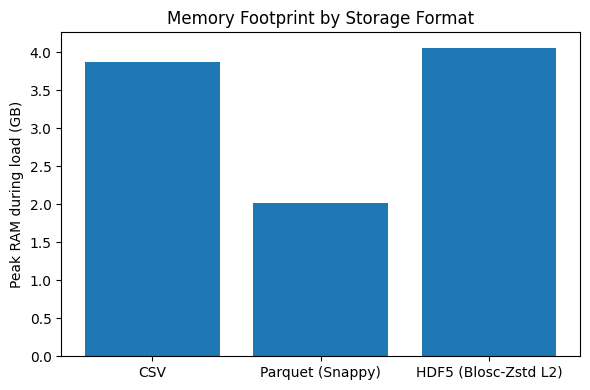

In [31]:
import matplotlib.pyplot as plt

# hard-coded benchmark numbers
formats = ["CSV", "Parquet (Snappy)", "HDF5 (Blosc-Zstd L2)"]
peak_ram  = [3.87, 2.02, 4.06] #in  GB

plt.figure(figsize=(6, 4))
plt.bar(formats, peak_ram)
plt.ylabel("Peak RAM during load (GB)")
plt.title("Memory Footprint by Storage Format")
plt.tight_layout()
plt.show()
